# General Nordgren Fracking Analytics


<img src="Animation_of_Hydraulic_Fracturing_fracking.gif" width="300">

## Altered-Proppant flow Problem

Nordgren's agreeable Fluid Continuity Differential; 
where q is the flow rate, q_L, fluid leak-off, A, area, t, time and X, displacement

$$
\frac{\partial q}{\partial X}+ q_L + \frac{\partial A}{\partial t}=0
$$

## Forward PINN Loss Functions

$$
U_{PINN} (t;\theta)\approx U(t)
$$

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ \frac{\partial q}{\partial X}+ q_L + \frac{\partial A}{\partial t}=0 \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$
Boundary Loss; where t=0
$$
u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2
$$
Physics Loss; where t_i=0
$$
\frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[\frac{\partial q}{\partial X}+ q_L + \frac{\partial A}{\partial t}=0 \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

Exact Solution;
$$
P_0=2\left[ \frac{E'^3 Q_0^2 \mu}{\pi^3 C_L H^6} \right]^\frac{1}{4} \times t^ \frac{1}{8}
$$

$$
u(t)=0.0039 \times P_0^8 \times Z^{-2}
$$
$$
u(t)=\frac {0.0039}{\left[ \frac{E'^3 Q_0^2 \mu}{\pi^3 C_L H^6} \right]^2} \cdot P_0^8
$$

In [68]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [69]:
"Analytical Solution for Nordgren Hydraulic Fracturing Model"

def exact_solution(P0, Q0, t):
    assert P0 < Q0
    a = 0.0039
    s = 1/z**2
    p = P0**8
    u = a*s*p
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

TypeError: 'float' object is not subscriptable

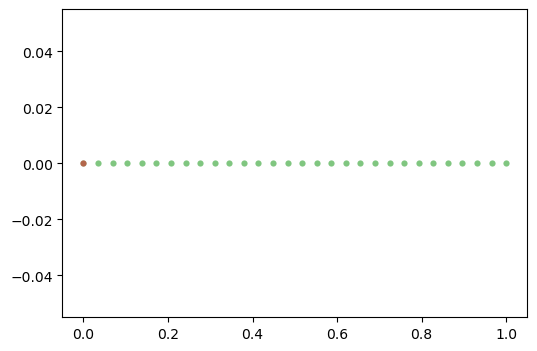

In [79]:
torch.manual_seed(123)

# define a neural network to train
# TODO: write code here
pinn = FCN(1,1,32,3)

# define boundary points, for the boundary loss
# TODO: write code here
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
# TODO: write code here
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
P0, Q0 = 2, 30
A, q, z, t = 2*P0, Q0**2, 50, 10
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(P0, Q0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4
    
    # compute boundary loss
    # TODO: write code here
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute physics loss
    # TODO: write code here
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + A*dudt + q)**2)
    
    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,4))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

In [ ]:
"Analytical Solution for Nordgren Hydraulic Fracturing Model"

def exact_solution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

* Invert PINN Loss Functions
$$
\mathcal{L}(\theta)= \min _{\theta} \frac{1}{N}\sum_{i}^N (U_{NN}(x_i;\theta)-(U_{true}(x_i))^2 + \frac{1}{M}\sum_{j}^M (\left[insert Nordgrens PDE \right](U_{NN}(x_j;\theta))
$$